# Atividade Computacional Redes Neurais 2025.1
---
Discente: João Victor Moreira Cardoso

---

## Problema de Regressão

Seja a função 

$$
f(\mathbf{x}) = \sum_{n=1}^{D}(x_n)^{2n} - exp\{-\sum_{n=1}^{D}\epsilon_n(x_n)^{2n}\}
$$

onde:
- $\mathbf{x} = [x_1\,\,x_2\,\,\dots\,\,x_n\,\,\dots\,\,x_D]^{T},\,\,\, x \in [-30,30]\,$;
- Cada $0 \leqslant \epsilon_n \leqslant 1$ é sorteado de uma distribuição uniforme $\implies$ podemos criar um vetor $\mathbf{\epsilon} = [\epsilon_1\,\,\epsilon_2\,\,\dots\,\,\epsilon_D]$ de mesma dimensão $D$;
---
Para $D=3$:

$$
f(\mathbf{x}) = (x_1)^{2}+(x_2)^{4}+(x_3)^{6} - exp\{-[\epsilon_1(x_1)^{2}+\epsilon_2(x_2)^{2}+\epsilon_3(x_3)^{6}]\}
$$

## Imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d import Axes3D

from math import sqrt
from tqdm import tqdm

import pandas as pd
pd.options.display.max_colwidth = 1000
pd.options.display.max_columns = 1000
pd.options.display.max_rows = 200

import sklearn
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_validate,train_test_split, GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder,MinMaxScaler,StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.svm import SVC, LinearSVC, SVR
from sklearn.kernel_ridge import KernelRidge

from sklearn.metrics import mean_squared_error, r2_score
import random
from random import seed,randrange
import requests
import io

import matplotlib.patches as mpatches
import seaborn as sns
import pdflatex

from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from scipy.linalg import norm

import warnings
warnings.filterwarnings("ignore")

## Dataset

### (a) Sorteio dos valores de $\epsilon_n$

In [2]:
np.random.seed(42)  # Para reprodutibilidade
D = 3 # Dimensão do vetor epsilon
n_points = 2000
epsilon = np.array(np.random.uniform(0,1,D))
print(f"Valores de epsilon_n sorteados: {epsilon}")


Valores de epsilon_n sorteados: [0.37454012 0.95071431 0.73199394]


### (b)(i) Geração dos pontos da função $(\vec{x}_n,f(\vec{x}_n))$

In [3]:
def f(x, epsilon):
    """Calcula a função f(x) conforme definida"""
    sum_x = np.sum([x_n**(2*(n+1)) for n, x_n in enumerate(x)]) # Termo da Soma
    exp_term = np.exp(-np.sum([epsilon[n] *(x_n**(2*(n+1))) for n, x_n in enumerate(x)])) # Termo Exponencial
    return sum_x - exp_term

# Gerar 2000 pontos aleatórios no intervalo [-30, 30]
X = np.random.uniform(-30, 30, (n_points, D))
y = np.array([f(x, epsilon) for x in X])


### (b)(ii) Informar os pontos da função $(\vec{x}_n,f(\vec{x}_n))$

In [4]:
print(f'Vetor X:\n', X, '\n')

Vetor X:
 [[  5.91950905 -20.63888157 -20.64032878]
 [-26.51498327  21.97056875   6.0669007 ]
 [ 12.48435467 -28.76493034  28.19459113]
 ...
 [-25.66720888  11.06612166   0.19322489]
 [ 15.90893099  -0.88256196 -21.03710183]
 [  8.89541724 -19.65681827  22.3436738 ]] 



In [5]:
print(f'Vetor y:\n', y, '\n')

Vetor y:
 [7.75028721e+07 2.83573653e+05 5.03021363e+08 ... 1.56550243e+04
 8.66795655e+07 1.24580062e+08] 



### (b)(iii) Visualização dos pontos da função $(\vec{x}_n,f(\vec{x}_n))$

#### Bidimensional


(b) Distribuição dos pontos:
Treinamento: 1500 pontos
Validação: 250 pontos
Teste: 250 pontos


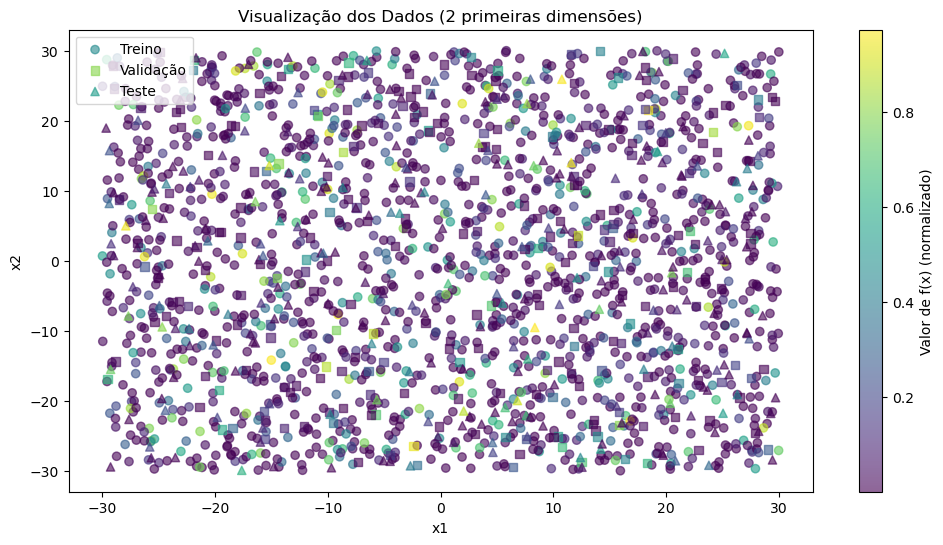

In [6]:
# Dividir em treino (1500), validação (250) e teste (250)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=500, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("\n(b) Distribuição dos pontos:")
print(f"Treinamento: {X_train.shape[0]} pontos")
print(f"Validação: {X_val.shape[0]} pontos")
print(f"Teste: {X_test.shape[0]} pontos")

# Normalizar os valores de y para o intervalo [0,1]
norm = Normalize(vmin=min(y_train.min(), y_val.min(), y_test.min()), 
                vmax=max(y_train.max(), y_val.max(), y_test.max()))

plt.figure(figsize=(12, 6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=norm(y_train), cmap='viridis', alpha=0.6, label='Treino')
plt.scatter(X_val[:, 0], X_val[:, 1], c=norm(y_val), cmap='viridis', marker='s', alpha=0.6, label='Validação')
plt.scatter(X_test[:, 0], X_test[:, 1], c=norm(y_test), cmap='viridis', marker='^', alpha=0.6, label='Teste')

# Adicionar barra de cores
cbar = plt.colorbar()
cbar.set_label('Valor de f(x) (normalizado)')

plt.title("Visualização dos Dados (2 primeiras dimensões)")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.show()

#### Tridimensional

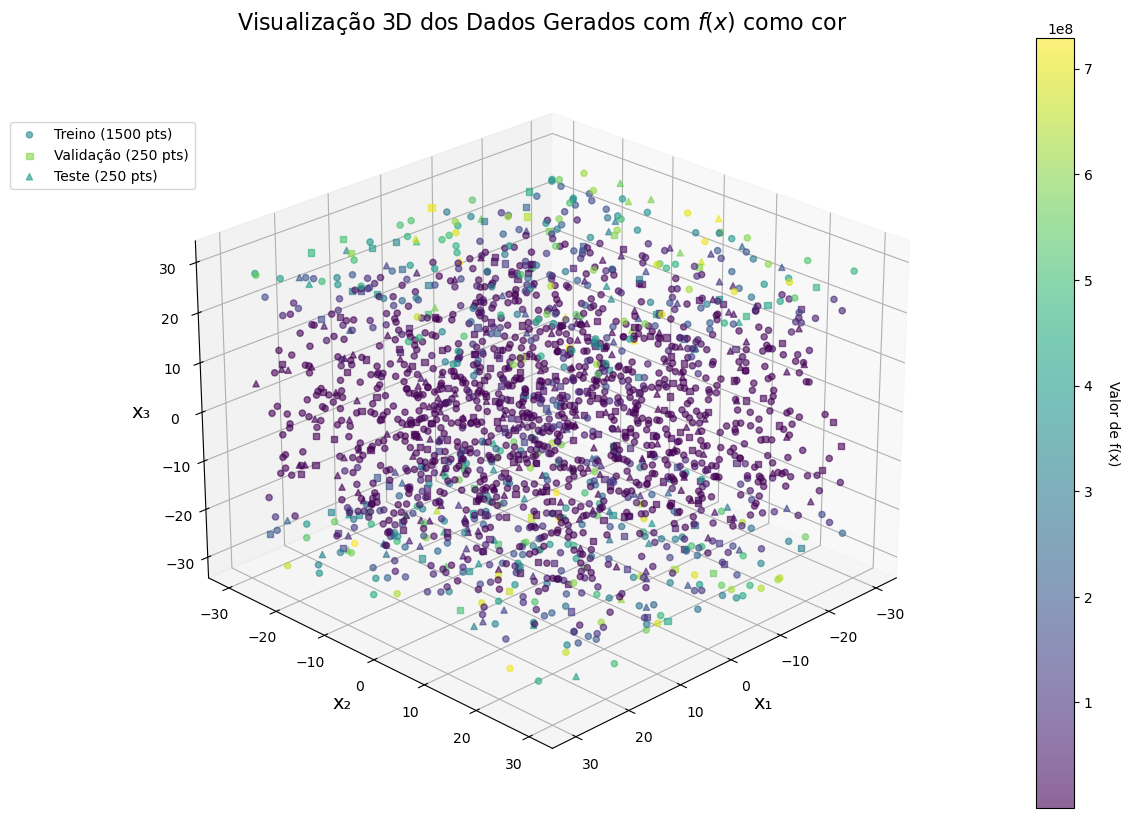

In [7]:
# Configuração do gráfico 3D
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot dos pontos de treinamento
sc_train = ax.scatter(X_train[:, 0], X_train[:, 1], X_train[:, 2], 
                      c=y_train, cmap='viridis', alpha=0.6, 
                      label='Treino (1500 pts)', marker='o')

# Plot dos pontos de validação
sc_val = ax.scatter(X_val[:, 0], X_val[:, 1], X_val[:, 2], 
                    c=y_val, cmap='viridis', alpha=0.6, 
                    label='Validação (250 pts)', marker='s')

# Plot dos pontos de teste
sc_test = ax.scatter(X_test[:, 0], X_test[:, 1], X_test[:, 2], 
                     c=y_test, cmap='viridis', alpha=0.6, 
                     label='Teste (250 pts)', marker='^')

# Configurações do gráfico
ax.set_title(f'Visualização 3D dos Dados Gerados com $f(x)$ como cor', fontsize=16)
ax.set_xlabel('x₁', fontsize=14)
ax.set_ylabel('x₂', fontsize=14)
ax.set_zlabel('x₃', fontsize=14)

# Adicionando barra de cores
cbar = fig.colorbar(sc_train, ax=ax, pad=0.1)
cbar.set_label('Valor de f(x)', rotation=270, labelpad=20)

# Ajustando a legenda
ax.legend(loc='upper left', bbox_to_anchor=(-0.2, 0.9))

# Ajustando o ângulo de visualização
ax.view_init(elev=25, azim=45)
plt.show()

## Treinamento

Como estamos tratando de um problema de regressão, uma vez que não temos as classes dos pontos bem definidas, temos que ajustar as métricas e os modelos para atuarem como regressores.

- Modelos:
    - MLP-BP de Três Camadas: usaremos o [MLPRegressor da Scikit-Learn](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html)
    - RBF de Três Camadas: construí uma rotina própria de RBF com k-means
    - SVM com Kernel: usaremos o [SVR da Scikit-Learn](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html)

- Métricas:
    - Mean Squared Error: usaremos o [MSE da Scikit-Learn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html) para analisar o quanto o modelo está errando
    - $R^2$ Score: usaremos o [$R^2$ da Scikit-Learn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html) para analisar o desempenho global dos modelos

### Função para avaliação de modelos

In [8]:
def evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test):
    """Avalia um modelo e retorna métricas"""
    model.fit(X_train, y_train)
    
    # Previsões
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    y_pred_test = model.predict(X_test)
    
    # Métricas
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_val = mean_squared_error(y_val, y_pred_val)
    mse_test = mean_squared_error(y_test, y_pred_test)
    
    r2_train = r2_score(y_train, y_pred_train)
    r2_val = r2_score(y_val, y_pred_val)
    r2_test = r2_score(y_test, y_pred_test)
    
    return {
        'mse': {'train': mse_train, 'val': mse_val, 'test': mse_test},
        'r2': {'train': r2_train, 'val': r2_val, 'test': r2_test}
    }, y_pred_train,y_pred_val,y_pred_test


### Normalização dos Dados

Fazemos isso para que os valores numéricos não estourem. Para tal, usamos o [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) que atua como um z-score:
$$
z=\frac{x - \mu}{\sigma}
$$

In [9]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1)).ravel()
y_val_scaled = scaler.transform(y_val.reshape(-1, 1)).ravel()
y_test_scaled = scaler.transform(y_test.reshape(-1, 1)).ravel()

### (c) MLP-BP de três camadas

Implementei um MLP de 3 camadas em que:
- Camada escondida contém apenas 20 neurônios;
- Função de ativação para o cálculo do Net é a 'ReLU' $\equiv$ Rectified Linear Unit Function
- Regra de Atualização dos Pesos: 'adam'
- Número Máximo de Iterações: 1000

In [10]:
print("\n(c) Treinando MLP-BP de três camadas...")
mlp = MLPRegressor(hidden_layer_sizes=(20,), activation='relu',
                solver='adam', max_iter=1000, random_state=42)

mlp_metrics, y_mlp_pred_train,y_mlp_pred_val,y_mlp_pred_test = evaluate_model(mlp, X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, X_test_scaled, y_test_scaled)
print("MSE - Treino:", mlp_metrics['mse']['train'], "| Validação:", mlp_metrics['mse']['val'], "| Teste:", mlp_metrics['mse']['test'])
print("R² - Treino:", mlp_metrics['r2']['train'], "| Validação:", mlp_metrics['r2']['val'], "| Teste:", mlp_metrics['r2']['test'])
#Imprimindo os Pesos e os Biases Finais Utilizados
print("\nPesos Finais Utilizados:")
print(mlp.coefs_)
print("\nBiases Finais Utilizados:")
print(mlp.intercepts_)


(c) Treinando MLP-BP de três camadas...
MSE - Treino: 0.022905393168026783 | Validação: 0.023485987908120867 | Teste: 0.03186481619301654
R² - Treino: 0.9770946068319732 | Validação: 0.9787385769190651 | Teste: 0.9712385445357153

Pesos Finais Utilizados:
[array([[ 5.56212016e-02,  6.12500640e-01,  3.28082084e-01,
         1.89035836e-01, -4.89446120e-01, -2.83459947e-01,
        -3.62582531e-02, -1.97322758e-02, -3.97863002e-61,
        -2.78736902e-01, -5.16187355e-01,  5.76768359e-02,
        -3.83919910e-02, -4.51444535e-01, -2.78850506e-01,
        -7.96659945e-02, -3.88482578e-01,  4.98694266e-03,
        -2.51186648e-01, -1.49928149e-01],
       [ 1.40628183e-02, -1.83040916e-01, -3.70123289e-01,
        -2.36351715e-01, -2.26176044e-01,  2.84212426e-01,
        -7.25825338e-03,  3.48854657e-02, -5.96131116e-63,
        -4.88616874e-01,  1.17057988e-01,  1.65943206e-02,
         1.83818016e-02, -1.86666254e-01,  3.20887315e-01,
        -7.10286558e-02,  1.81854737e-01, -6.69581

### (d) RBF de três camadas

Construí uma RBF de forma que:
- Usa K-means para encontrar centros representativos nos dados em que $K=50$ centros;
- Calcula a ativação de cada neurônio RBF usando função Gaussiana: $φ(||\vec{x}_n - c_i||) = exp(-||\vec{x}_n - c_i||² / (2σ²))$, o que faz com que cada neurônio responda mais intensamente a pontos próximos ao seu centro;
- Camada de saída com combinação linear das ativações RBF;
- Usa pseudoinversa para resolver o sistema linear (mais estável que inversão direta);

In [11]:
from scipy.spatial.distance import cdist
from sklearn.base import BaseEstimator, RegressorMixin

print("\n(d) Treinando RBF de três camadas...")


class RBFNetwork(BaseEstimator, RegressorMixin):
    def __init__(self, n_centers=50, sigma=1.0):
        self.n_centers = n_centers # Quantidae de Neurônios na Camada Oculta
        self.sigma = sigma # Parâmetro de largura das funções RBF
        
    def _rbf_function(self, X, centers):
        # Usando cdist para calcular as distâncias euclidianas
        return np.exp(-cdist(X, centers, 'sqeuclidean') / (2 * self.sigma**2))
    
    def fit(self, X, y):
        # Camada 1: Encontrar centros com K-means
        kmeans = KMeans(n_clusters=self.n_centers, random_state=42)
        kmeans.fit(X)
        self.centers_ = kmeans.cluster_centers_
        
        # Camada 2: Calcular saídas RBF
        rbf_features = self._rbf_function(X, self.centers_)
        
        # Camada 3: Regressão linear (usando pseudoinversa para estabilidade numérica)
        self.weights_ = np.linalg.pinv(rbf_features) @ y
        return self
        
    def predict(self, X):
        rbf_features = self._rbf_function(X, self.centers_)
        return rbf_features @ self.weights_
    
rbf = RBFNetwork()

rbf_metrics, y_rbf_pred_train,y_rbf_pred_val,y_rbf_pred_test = evaluate_model(rbf, X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, X_test_scaled, y_test_scaled)
print("MSE - Treino:", rbf_metrics['mse']['train'], "| Validação:", rbf_metrics['mse']['val'], "| Teste:", rbf_metrics['mse']['test'])
print("R² - Treino:", rbf_metrics['r2']['train'], "| Validação:", rbf_metrics['r2']['val'], "| Teste:", rbf_metrics['r2']['test'])

# Imprimindo os centros finais
print("\nCentros finais utilizados:")
print(rbf.centers_)


(d) Treinando RBF de três camadas...
MSE - Treino: 0.13515109264031655 | Validação: 0.13925535290069518 | Teste: 0.15757398711348578
R² - Treino: 0.8648489073596834 | Validação: 0.8739347484172545 | Teste: 0.8577723723481726

Centros finais utilizados:
[[ 0.46057846  0.80667904 -0.48209908]
 [-1.12096508 -0.50048307  1.36988296]
 [ 0.55209187  0.25296892  1.35018956]
 [-0.97716343 -0.23870371 -1.37668172]
 [ 0.44629816 -1.12993786 -0.93862846]
 [-1.39797151  1.01527053  0.3170208 ]
 [ 0.17727225 -1.2814488   0.74570554]
 [ 0.63036203 -0.38260551  0.29072563]
 [-0.66592946  0.87629654 -0.12471984]
 [-1.33550674 -1.43748992 -0.05658016]
 [-1.39657733  1.15400183 -1.3318278 ]
 [ 1.22895625  1.29348949  0.81496228]
 [ 1.26485206  0.19411633 -1.11954386]
 [ 1.34691819 -0.81981882 -0.0292166 ]
 [-0.35147353  1.03619091  1.47464359]
 [-1.05242236 -1.3740765   0.59329821]
 [-1.36420467 -1.08527224 -1.27206692]
 [-0.20335398 -0.04853397 -0.28487743]
 [-0.55933835  1.11385022 -1.33220225]
 [ 1.

### (e) SVM com Kernel

Implementei um SVM Regressor (SVR) de tal forma que:
- Kernel do SVR é RBF;
    - Kernel Gaussiano: $\mathbf{K}(x, x') = exp(-\gamma * ||x - x'||^2)$
        - $\gamma$: controla a "largura";
        - $||x - x'||^2$: é a distância euclidiana ao quadrado.
    - Com essa Tranformação de Núcleo, conseguimos mapear o problema para um espaço de dimensão superior e fazer a regressão
- gamma: Controla o alcance da influência de cada ponto de treinamento
    - Valores baixos: decisão mais suave (considera pontos mais distantes);
    - Valores altos: decisão mais complexa (considera pontos mais próximos);

In [17]:
print("\n(e) Treinando SVM com Kernel...")
svm = SVR(kernel='rbf', gamma=0.2)

svm_metrics, y_svm_pred_train,y_svm_pred_val,y_svm_pred_test = evaluate_model(svm, X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, X_test_scaled, y_test_scaled)
print("MSE - Treino:", svm_metrics['mse']['train'], "| Validação:", svm_metrics['mse']['val'], "| Teste:", svm_metrics['mse']['test'])
print("R² - Treino:", svm_metrics['r2']['train'], "| Validação:", svm_metrics['r2']['val'], "| Teste:", svm_metrics['r2']['test'])

# Imprimindo os centros finais
print("\nVetores de Suporte finais utilizados:")
print('\nÍndices\n',svm.support_)
print('\nVetores de Suporte\n',svm.support_vectors_)
print('\nNúmero de Vetores de Suporte\n',len(svm.support_vectors_))



(e) Treinando SVM com Kernel...
MSE - Treino: 0.20151564363180122 | Validação: 0.2293013090556594 | Teste: 0.24061036682569978
R² - Treino: 0.7984843563681988 | Validação: 0.7924178380778762 | Teste: 0.7828230262561755

Vetores de Suporte finais utilizados:

Índices
 [   0    2    7   10   14   15   16   17   18   19   20   21   22   24
   25   27   29   30   31   32   34   35   36   37   38   40   41   45
   46   47   49   51   53   54   55   56   57   58   59   64   66   67
   68   69   71   72   73   74   76   78   79   80   82   85   88   92
   95   96   97   98  100  102  103  104  106  107  109  111  115  117
  118  119  120  121  122  124  125  126  129  130  131  132  133  136
  137  138  140  141  143  144  145  146  147  149  151  153  157  158
  159  160  161  162  163  165  170  171  172  176  177  179  181  182
  183  184  187  189  192  193  196  200  201  202  203  204  207  208
  211  212  216  218  219  220  221  223  224  226  227  228  231  232
  233  234  237  239 

### (f) Comparação dos resultados no cojunto de teste


Comparação dos modelos:

MLP-BP:
MSE Teste: 0.0319 | R² Teste: 0.9712

RBF:
MSE Teste: 0.1576 | R² Teste: 0.8578

SVM:
MSE Teste: 0.2406 | R² Teste: 0.7828


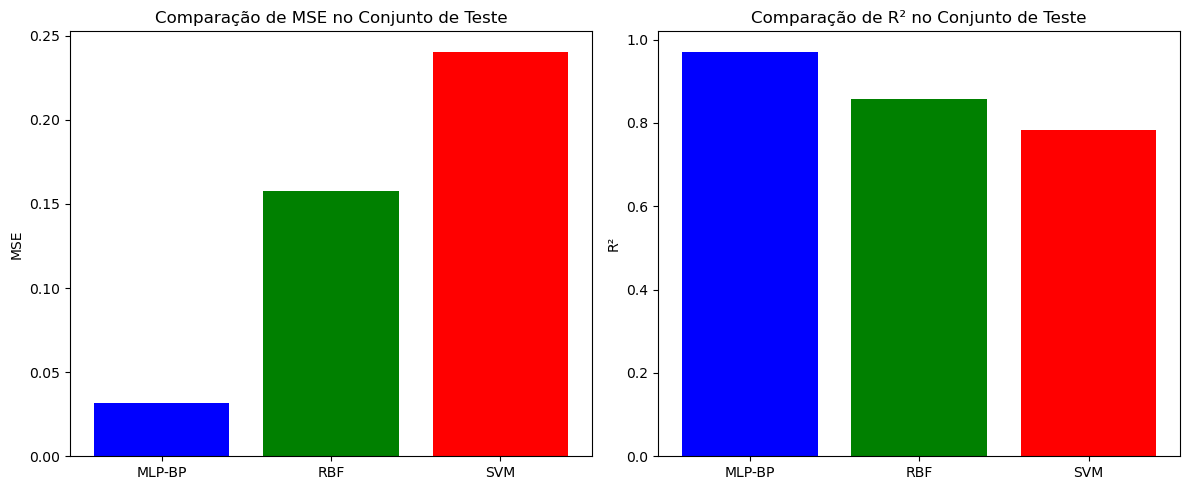

In [13]:
print("\nComparação dos modelos:")
print("\nMLP-BP:")
print(f"MSE Teste: {mlp_metrics['mse']['test']:.4f} | R² Teste: {mlp_metrics['r2']['test']:.4f}")

print("\nRBF:")
print(f"MSE Teste: {rbf_metrics['mse']['test']:.4f} | R² Teste: {rbf_metrics['r2']['test']:.4f}")

print("\nSVM:")
print(f"MSE Teste: {svm_metrics['mse']['test']:.4f} | R² Teste: {svm_metrics['r2']['test']:.4f}")

# Plotar comparação
models = ['MLP-BP', 'RBF', 'SVM']
mse_test = [mlp_metrics['mse']['test'], rbf_metrics['mse']['test'], svm_metrics['mse']['test']]
r2_test = [mlp_metrics['r2']['test'], rbf_metrics['r2']['test'], svm_metrics['r2']['test']]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.bar(models, mse_test, color=['blue', 'green', 'red'])
plt.title('Comparação de MSE no Conjunto de Teste')
plt.ylabel('MSE')

plt.subplot(1, 2, 2)
plt.bar(models, r2_test, color=['blue', 'green', 'red'])
plt.title('Comparação de R² no Conjunto de Teste')
plt.ylabel('R²')

plt.tight_layout()
plt.show()


### Gerando gráficos de comparação para MLP, RBF e SVM

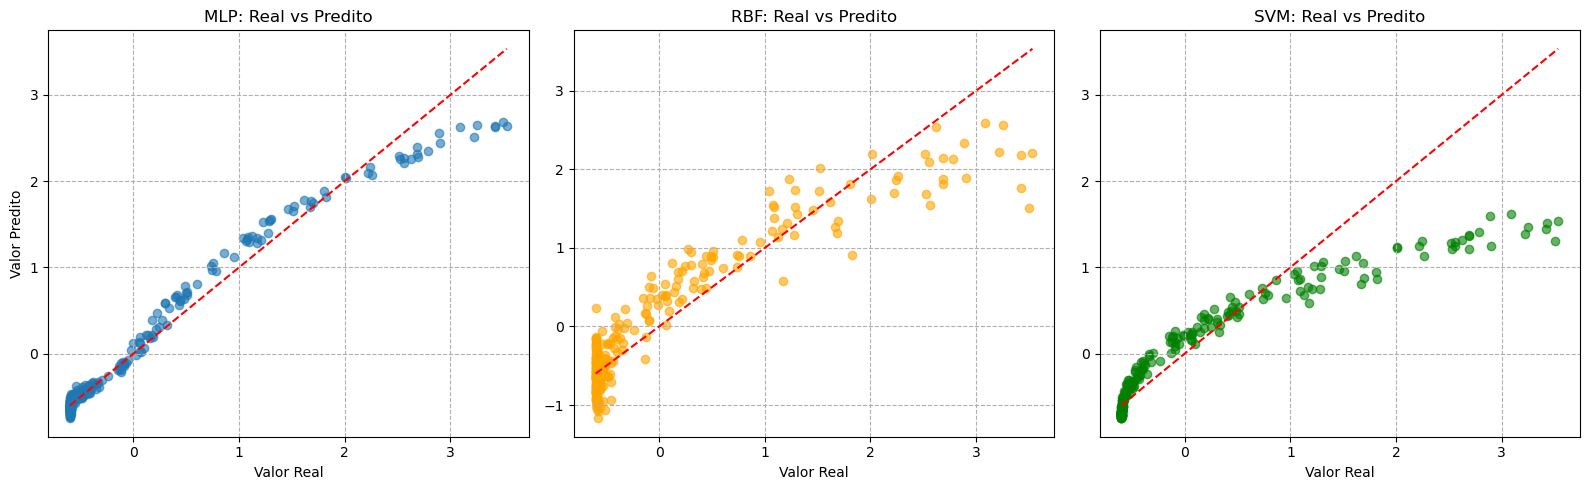

In [14]:
fi,ax=plt.subplots(1,3,sharex=False,figsize=(16,5))

# Gráfico MLP
ax[0].scatter(y_test_scaled, y_mlp_pred_test, alpha=0.6, label='MLP')
ax[0].plot([min(y_test_scaled), max(y_test_scaled)], [min(y_test_scaled), max(y_test_scaled)], 'r--')
ax[0].set_xlabel("Valor Real")
ax[0].set_ylabel("Valor Predito")
ax[0].set_title("MLP: Real vs Predito")
ax[0].grid(linestyle='dashed')

# Gráfico RBF
ax[1].scatter(y_test_scaled, y_rbf_pred_test, alpha=0.6, label='RBF', color='orange')
ax[1].plot([min(y_test_scaled), max(y_test_scaled)], [min(y_test_scaled), max(y_test_scaled)], 'r--')
ax[1].set_xlabel("Valor Real")
ax[1].set_title("RBF: Real vs Predito")
ax[1].grid(linestyle='dashed')

# Gráfico SVM
ax[2].scatter(y_test_scaled, y_svm_pred_test, alpha=0.6, label='SVM', color='green')
ax[2].plot([min(y_test_scaled), max(y_test_scaled)], [min(y_test_scaled), max(y_test_scaled)], 'r--')
ax[2].set_xlabel("Valor Real")
ax[2].set_title("SVM: Real vs Predito")
ax[2].grid(linestyle='dashed')

plt.tight_layout()
plt.show()

## Relatório do Problema de Regressão

### (a) Sorteio dos valores de $\epsilon_n$
- Valores de epsilon_n sorteados: [0.37454012 0.95071431 0.73199394]

### (b)(i, ii) Geração e informação dos pontos $(\vec{x}_n,y(f(\vec{x}_n)))$
- $\vec x_n$:
 [[  5.91950905 -20.63888157 -20.64032878]
 [-26.51498327  21.97056875   6.0669007 ]
 [ 12.48435467 -28.76493034  28.19459113]
 ...
 [-25.66720888  11.06612166   0.19322489]
 [ 15.90893099  -0.88256196 -21.03710183]
 [  8.89541724 -19.65681827  22.3436738 ]] 

- $y=f(\vec x_n)$:
 [7.75028721e+07 2.83573653e+05 5.03021363e+08 ... 1.56550243e+04
 8.66795655e+07 1.24580062e+08] 

### (b)(iii) Visualização dos pontos $(\vec{x}_n,y(f(\vec{x}_n)))$ em 2D
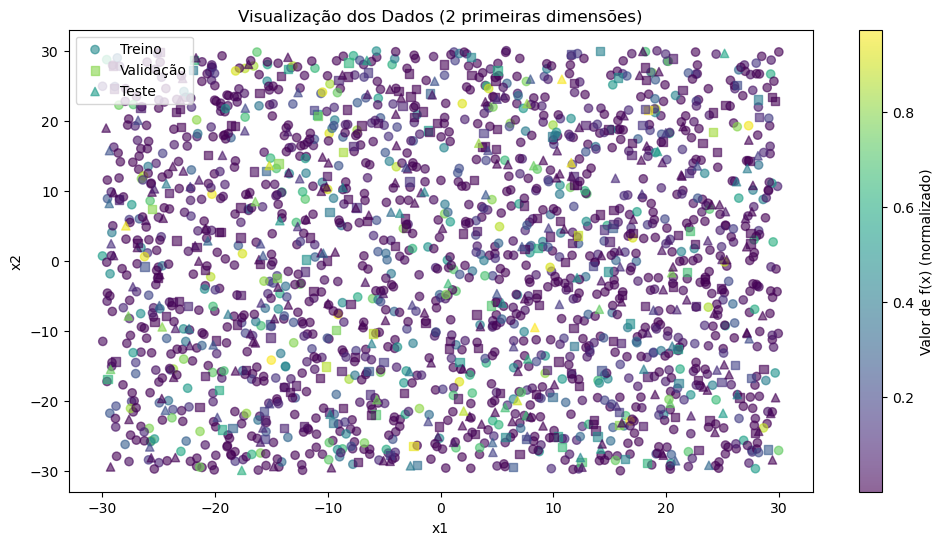
### (b)(iii) Visualização dos pontos $(\vec{x}_n,y(f(\vec{x}_n)))$ em 3D
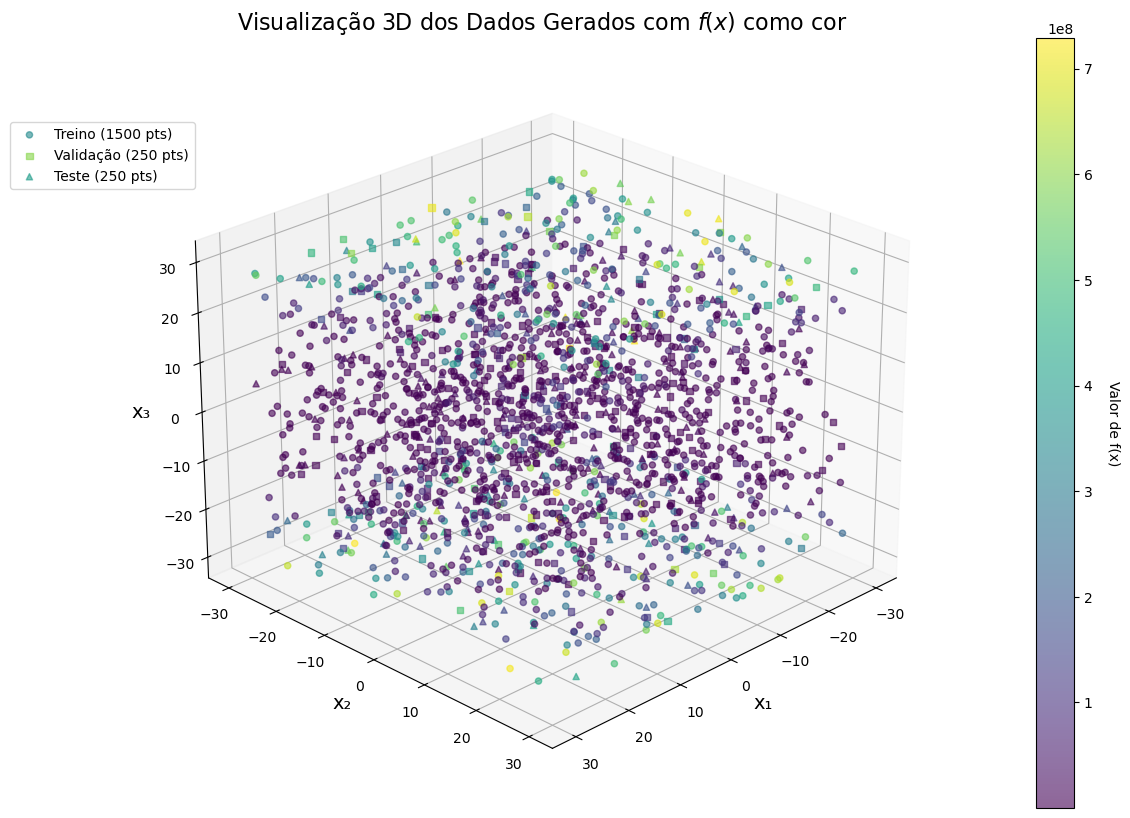

### Métricas Escolhidas para avaliação dos modelos
Como estamos tratando de um problema de regressão, uma vez que não temos as classes dos pontos bem definidas, temos que ajustar as métricas e os modelos para atuarem como regressores.

- Modelos:
    - MLP-BP de Três Camadas: usaremos o [MLPRegressor da Scikit-Learn](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html)
    - RBF de Três Camadas: construí uma rotina própria de RBF com k-means
    - SVM com Kernel: usaremos o [SVR da Scikit-Learn](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html)

- Métricas:
    - Mean Squared Error: usaremos o [MSE da Scikit-Learn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html) para analisar o quanto o modelo está errando
    - $R^2$ Score: usaremos o [$R^2$ da Scikit-Learn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html) para analisar o desempenho global dos modelos

### Normalização dos Dados
Fazemos isso para que os valores numéricos não estourem. Para tal, usamos o [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) que atua como um z-score:
$$
z=\frac{x - \mu}{\sigma}
$$

### (c) MLP-BP de três camadas
Implementei um MLP de 3 camadas em que:
- Camada escondida contém apenas 20 neurônios;
- Função de ativação para o cálculo do Net é a 'ReLU' $\equiv$ Rectified Linear Unit Function;
- Regra de Atualização dos Pesos: 'adam';
- Número Máximo de Iterações: 1000;
- Resultados do MLP-BP de três camadas:
   - MSE - Treino: 0.022905393168026783 | Validação: 0.023485987908120867 | Teste: 0.03186481619301654
   - R² - Treino: 0.9770946068319732 | Validação: 0.9787385769190651 | Teste: 0.9712385445357153

   - Pesos Finais Utilizados:
   [array([[ 5.56212016e-02,  6.12500640e-01,  3.28082084e-01,
            1.89035836e-01, -4.89446120e-01, -2.83459947e-01,
         -3.62582531e-02, -1.97322758e-02, -3.97863002e-61,
         -2.78736902e-01, -5.16187355e-01,  5.76768359e-02,
         -3.83919910e-02, -4.51444535e-01, -2.78850506e-01,
         -7.96659945e-02, -3.88482578e-01,  4.98694266e-03,
         -2.51186648e-01, -1.49928149e-01],
         [ 1.40628183e-02, -1.83040916e-01, -3.70123289e-01,
         -2.36351715e-01, -2.26176044e-01,  2.84212426e-01,
         -7.25825338e-03,  3.48854657e-02, -5.96131116e-63,
         -4.88616874e-01,  1.17057988e-01,  1.65943206e-02,
            1.83818016e-02, -1.86666254e-01,  3.20887315e-01,
         -7.10286558e-02,  1.81854737e-01, -6.69581673e-03,
            3.09769632e-01, -1.29339866e-02],
         [-9.31233936e-01, -1.16606909e-01, -1.13273809e-01,
            1.40837402e-01, -7.17799313e-02,  1.43688721e-01,
         -1.06183432e+00, -4.02908961e-01,  2.66097948e-71,
         -7.96870519e-01,  2.63711555e-01,  1.21006938e+00,
            1.20603132e+00,  9.27943230e-01,  4.85350649e-01,
            1.03802501e+00, -9.96497759e-01, -1.35960828e+00,
         -1.39244625e-01, -1.19887275e-01]]), array([[ 1.30712799e+00],
         [ 2.74369340e-01],
         [-1.70375390e-01],
         [ 8.68656915e-04],
         [-2.05611379e-01],
         [-1.91101584e-01],
         [ 1.62934112e+00],
         [ 3.11263305e-01],
         [ 8.96725843e-16],
         [ 2.15004699e-01],
         [-3.59790385e-01],
         [ 1.91368194e+00],
         [ 1.85109949e+00],
         [ 3.55706227e-01],
         [ 3.27809306e-01],
         [ 5.61893325e-01],
         [ 4.61516229e-01],
         [ 1.86608865e+00],
         [-9.90223556e-02],
         [-3.78395979e-01]])]

   - Biases Finais Utilizados:
   [array([-0.98464082, -0.42992884,  0.66462835, -0.25154962, -0.12640038,
         0.20564022, -1.32168199,  0.48739429, -0.43459985, -0.28728446,
         0.43515136, -1.44992538, -1.55024064,  0.28152533,  0.11840356,
         -1.11233501, -0.64179302, -1.65626972, -0.1936412 , -0.4497777 ]), array([-0.68212485])]

### (d) RBF de três camadas
Construí uma RBF de forma que:
- Usa K-means para encontrar centros representativos nos dados em que $K=50$ centros;
- Calcula a ativação de cada neurônio RBF usando função Gaussiana: $φ(||\vec{x}_n - c_i||) = exp(-||\vec{x}_n - c_i||² / (2σ²))$, o que faz com que cada neurônio responda mais intensamente a pontos próximos ao seu centro;
- Camada de saída com combinação linear das ativações RBF;
- Usa pseudoinversa para resolver o sistema linear (mais estável que inversão direta);
- Resultados do RBF de três camadas:
   - MSE - Treino: 0.13515109264031655 | Validação: 0.13925535290069518 | Teste: 0.15757398711348578
   - R² - Treino: 0.8648489073596834 | Validação: 0.8739347484172545 | Teste: 0.8577723723481726

   - Centros finais utilizados:
   [[ 0.46057846  0.80667904 -0.48209908]
   [-1.12096508 -0.50048307  1.36988296]
   [ 0.55209187  0.25296892  1.35018956]
   [-0.97716343 -0.23870371 -1.37668172]
   [ 0.44629816 -1.12993786 -0.93862846]
   [-1.39797151  1.01527053  0.3170208 ]
   [ 0.17727225 -1.2814488   0.74570554]
   [ 0.63036203 -0.38260551  0.29072563]
   [-0.66592946  0.87629654 -0.12471984]
   [-1.33550674 -1.43748992 -0.05658016]
   [-1.39657733  1.15400183 -1.3318278 ]
   [ 1.22895625  1.29348949  0.81496228]
   [ 1.26485206  0.19411633 -1.11954386]
   [ 1.34691819 -0.81981882 -0.0292166 ]
   [-0.35147353  1.03619091  1.47464359]
   [-1.05242236 -1.3740765   0.59329821]
   [-1.36420467 -1.08527224 -1.27206692]
   [-0.20335398 -0.04853397 -0.28487743]
   [-0.55933835  1.11385022 -1.33220225]
   [ 1.3183862   1.41131188 -0.21811388]
   [ 0.4846463  -0.66474595  1.34084913]
   [-1.30422189 -0.53611684 -0.16294738]
   [-1.3336035   0.3813164  -0.6792554 ]
   [ 1.28151367  1.23657816 -1.17597802]
   [ 1.20627435 -1.43333979 -0.06327635]
   [ 0.19361677  1.50641172  0.08969605]
   [ 1.18043592 -1.00416369 -1.27757327]
   [ 0.28272739  0.04678045 -1.37124074]
   [-0.13629348 -1.17720707  0.01713341]
   [ 1.40436821 -0.03219523 -0.28739446]
   [-0.19598484  1.64606164 -1.21414266]
   [ 1.14146745 -1.35083632  1.25992219]
   [-0.43185477 -1.33891155 -1.39596256]
   [-1.45297857 -1.17696623  1.35046319]
   [-1.15104237  1.41016413 -0.58560968]
   [ 0.58313732 -0.21055254 -0.60946469]
   [-0.30018078 -0.27949251  1.07632484]
   [-0.70783101 -1.1792492  -0.74705196]
   [-1.45697297  0.40331522  1.21990172]
   [ 1.43408837  0.50653655  1.40248075]
   [-1.2865405   1.40003685  1.35583463]
   [-0.32846925  0.46561854 -0.98674189]
   [ 1.36083124  0.3166733   0.48004559]
   [-0.80682908 -0.10607417  0.48862153]
   [ 0.64964423  1.27276724  1.38282704]
   [ 0.18852653  0.65797224  0.61043924]
   [ 1.2953145  -0.60951677  0.84539558]
   [ 0.52215632  1.17748815 -1.23827974]
   [-0.26761052 -1.11587013  1.46214598]
   [-0.703207    1.22862954  0.78430594]]

### (e) SVM com Kernel
Implementei um SVM Regressor (SVR) de tal forma que:
- Kernel do SVR é RBF;
    - Kernel Gaussiano: $\mathbf{K}(x, x') = exp(-\gamma * ||x - x'||^2)$
        - $\gamma$: controla a "largura";
        - $||x - x'||^2$: é a distância euclidiana ao quadrado.
    - Com essa Tranformação de Núcleo, conseguimos mapear o problema para um espaço de dimensão superior e fazer a regressão
- gamma: Controla o alcance da influência de cada ponto de treinamento
    - Valores baixos: decisão mais suave (considera pontos mais distantes);
    - Valores altos: decisão mais complexa (considera pontos mais próximos);
- Resultados do SVM com Kernel:
    - MSE - Treino: 0.2015156436318011 | Validação: 0.22930130905565943 | Teste: 0.2406103668256992
    - R² - Treino: 0.7984843563681989 | Validação: 0.7924178380778762 | Teste: 0.782823026256176
    - Vetores de Suporte finais utilizados:

      - Índices
      [   0    2    7   10   14   15   16   17   18   19   20   21   22   24
         25   27   29   30   31   32   34   35   36   37   38   40   41   45
         46   47   49   51   53   54   55   56   57   58   59   64   66   67
         68   69   71   72   73   74   76   78   79   80   82   85   88   92
         95   96   97   98  100  102  103  104  106  107  109  111  115  117
      118  119  120  121  122  124  125  126  129  130  131  132  133  136
      137  138  140  141  143  144  145  146  147  149  151  153  157  158
      159  160  161  162  163  165  170  171  172  176  177  179  181  182
      183  184  187  189  192  193  196  200  201  202  203  204  207  208
      211  212  216  218  219  220  221  223  224  226  227  228  231  232
      233  234  237  239  240  242  243  244  245  246  248  249  252  257
      258  259  260  263  266  267  268  269  271  272  274  276  277  278
      279  282  284  286  288  290  291  292  293  294  296  297  299  302
      303  304  308  309  311  312  313  317  319  321  323  324  325  326
      327  328  330  331  333  334  335  338  339  340  341  344  345  346
      347  348  351  352  355  356  357  358  359  360  363  364  368  369
      370  371  372  373  375  376  377  378  381  382  384  386  387  388
      389  390  391  392  395  399  400  401  402  404  406  407  409  410
      411  412  413  416  420  421  422  424  425  426  427  428  429  431
      432  433  438  443  446  448  449  450  451  453  454  455  456  457
      458  459  460  462  464  465  466  467  470  471  472  474  475  476
      477  478  479  481  482  485  486  487  488  489  491  492  493  494
      495  498  502  503  504  505  506  509  510  512  513  514  517  518
      519  522  523  524  526  527  529  531  532  534  536  538  539  540
      541  545  547  548  550  553  557  560  562  564  566  567  568  572
      577  579  580  582  584  586  588  589  590  591  593  594  596  597
      598  599  600  603  607  609  611  614  615  616  617  618  620  623
      624  626  628  629  630  631  632  635  636  637  642  643  644  645
      646  647  648  650  652  654  657  658  659  661  662  663  668  671
      672  673  674  677  678  681  683  684  685  687  688  690  691  694
      695  696  698  699  702  707  708  709  711  712  713  714  715  716
      719  720  724  725  726  727  730  731  732  733  734  735  739  740
      741  742  744  746  749  750  751  752  755  758  759  760  761  762
      763  764  770  771  773  775  778  779  780  781  782  784  787  788
      789  795  796  798  799  800  801  802  804  805  806  807  808  809
      810  811  812  813  816  817  818  819  820  821  822  828  829  831
      834  835  837  838  839  841  842  843  844  845  846  848  849  850
      852  854  855  858  859  860  862  863  865  866  867  868  870  872
      873  875  876  877  878  879  881  882  885  886  887  889  890  892
      893  897  898  899  902  903  904  907  908  909  910  911  913  914
      915  917  918  919  920  924  926  927  929  930  931  933  936  937
      938  939  940  941  942  943  945  946  947  948  950  951  952  954
      955  960  961  963  965  967  968  969  970  972  973  975  976  978
      980  981  982  984  986  987  988  991  992  993  994  995  996  997
      998 1001 1002 1004 1006 1007 1008 1009 1011 1012 1013 1014 1015 1016
      1017 1020 1021 1022 1023 1024 1025 1027 1028 1030 1031 1032 1033 1034
      1036 1038 1039 1040 1042 1043 1045 1046 1047 1048 1049 1050 1051 1053
      1055 1057 1058 1062 1063 1064 1067 1068 1069 1070 1072 1075 1076 1079
      1080 1082 1085 1086 1089 1093 1094 1095 1096 1098 1100 1101 1102 1103
      1104 1106 1107 1109 1110 1114 1115 1116 1117 1118 1126 1129 1131 1133
      1135 1138 1142 1143 1144 1145 1147 1151 1154 1155 1156 1157 1158 1160
      1161 1162 1163 1164 1166 1168 1169 1172 1174 1175 1177 1178 1179 1180
      1182 1183 1184 1185 1186 1187 1190 1192 1193 1194 1195 1197 1198 1199
      1204 1207 1208 1209 1210 1211 1212 1213 1214 1215 1216 1217 1218 1220
      1224 1226 1230 1234 1235 1237 1238 1239 1240 1241 1243 1244 1247 1253
      1254 1255 1256 1257 1258 1259 1261 1263 1264 1265 1268 1269 1270 1272
      1273 1275 1276 1277 1278 1279 1280 1282 1284 1285 1286 1287 1289 1290
      1291 1292 1293 1295 1299 1300 1305 1306 1310 1311 1314 1315 1316 1317
      1318 1322 1324 1325 1327 1330 1331 1332 1335 1337 1338 1339 1340 1342
      1343 1344 1345 1346 1347 1348 1349 1351 1352 1353 1355 1357 1358 1359
      1362 1364 1365 1366 1367 1368 1371 1372 1373 1374 1377 1378 1379 1380
      1382 1385 1386 1390 1392 1395 1397 1398 1399 1400 1403 1405 1406 1408
      1409 1410 1411 1413 1415 1416 1417 1418 1419 1420 1421 1423 1427 1428
      1430 1431 1433 1434 1435 1436 1438 1440 1441 1443 1444 1445 1446 1448
      1449 1450 1451 1452 1455 1458 1459 1460 1461 1462 1463 1465 1467 1468
      1469 1471 1472 1473 1474 1475 1476 1477 1478 1479 1480 1481 1482 1483
      1484 1489 1490 1493 1494 1495 1499]

      - Vetores de Suporte
      [[ 0.82461638 -0.9001924  -1.48840236]
      [ 0.47088953  0.5921529  -1.12575627]
      [ 0.92872525  0.0935221   1.27287808]
      ...
      [ 1.37874781 -0.98483782 -1.45877739]
      [-0.62526333  1.39017075  1.77375601]
      [-0.25310929 -1.57161501 -0.78873243]]

      - Número de Vetores de Suporte: 931

### (f) Comparação dos resultados no conjunto de teste
- MLP-BP:
   - MSE Teste: 0.0319 | R² Teste: 0.9712

- RBF:
   - MSE Teste: 0.1576 | R² Teste: 0.8578

- SVM:
   - MSE Teste: 0.2406 | R² Teste: 0.7828

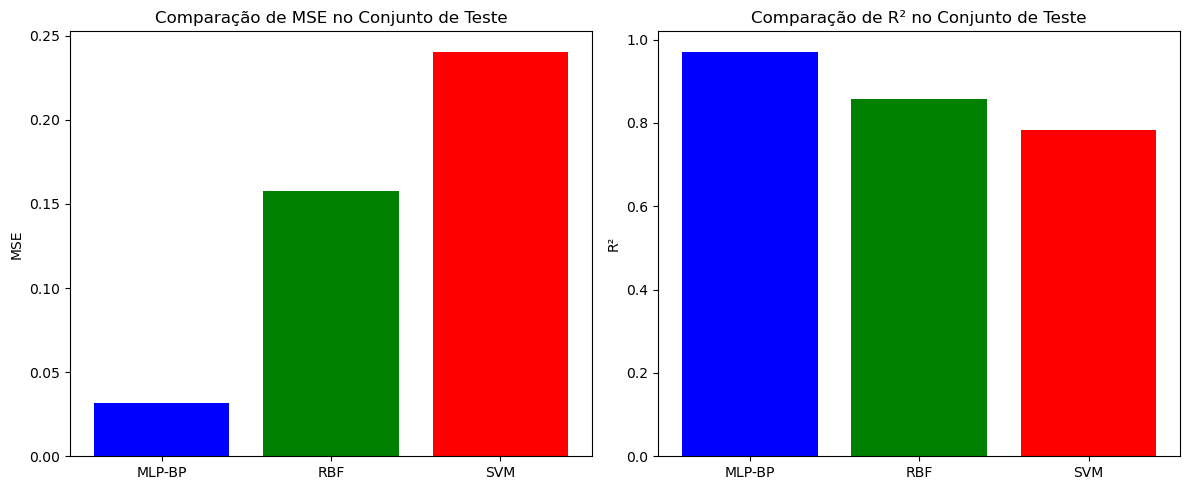
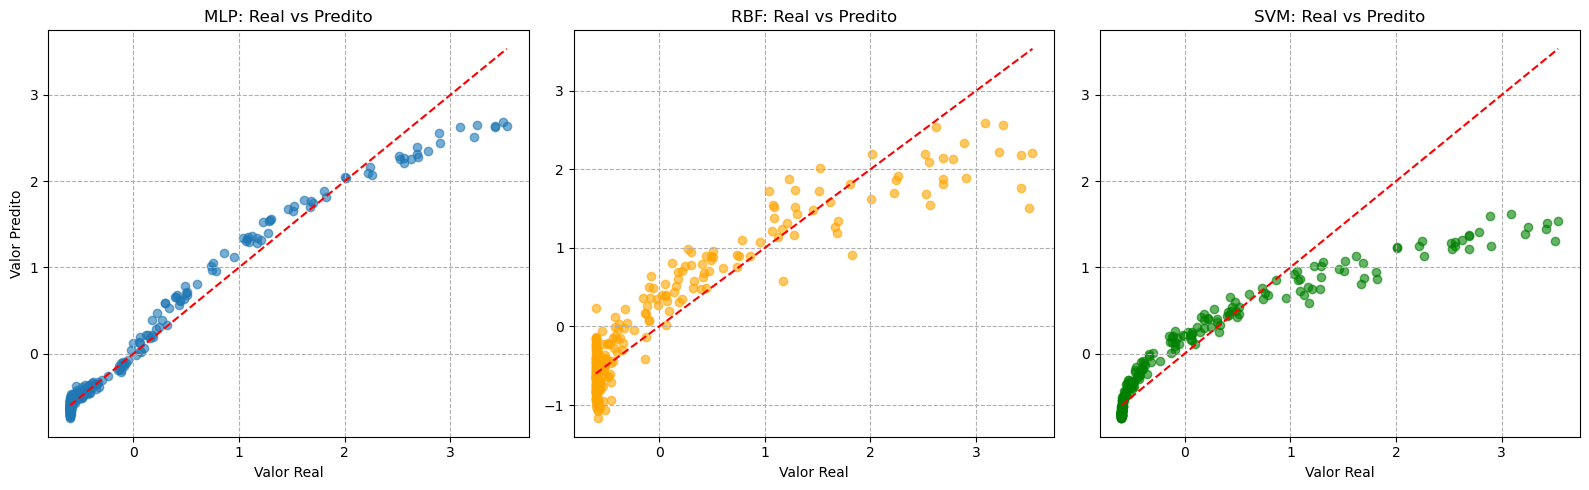

### Considerações Finais

1. O MLP-BP apresentou o melhor desempenho geral, com menor MSE e maior R² no conjunto de teste. Isso era esperado, pois redes neurais multicamadas são aproximadores universais de funções. O principal destaque vai para a rápida convergência do modelo que com menos robustez que os outros modelos (converge com menos de 1000 iterações e possui apenas 20 neurônios na camada oculta), consegue ter um desempenho superior aos outros dois. Contudo, conseguiríamos ajustar os outros modelos para que desempenhassem de forma parecida (ponto 4. deste breve relatório), porém aumentando suas complexidades.

2. O RBF teve desempenho intermediário. Ele funciona bem para problemas com características radialmente simétricas, mas pode ter dificuldade com funções mais complexas.

3. O SVM com kernel RBF teve o "pior" desempenho neste problema. SVMs são poderosos para classificação binária, mas podem ser menos eficientes para problemas de regressão complexos
como este.

4. Pelos desempenhos nas etapas de validação, os modelos não me parecem ter perdido a capacidade de generalização.

5. Há modos de aumentar as respectivas acurácias (aqui, vistas pelo score $R^2$). O problema passa a ser analisar se não há overfitting dos modelos ao aumentar seus desempenhos:
   - MLP-BP: Aumentar o número de neurônios na camada escondida
   - RBF: Aumentar o número de centros na região de decisão
   - SVM com Kernel RBF: Aumentar o parâmetro gamma que controla o alcance da influência dos pontos no problema

6. A função proposta parece ser melhor aproximada pela arquitetura do MLP-BP.